In [29]:
# Imports
import numpy as np
import csv
from collections import Counter
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import pickle

# Load data

In [2]:
train = pd.read_csv(os.path.join("cs5228", "train.csv"))
X_train = train.drop(["exceeds50K"], axis=1)
y_train = train["exceeds50K"]
X_test = pd.read_csv(os.path.join("cs5228", "test.csv"))
print(list(X_train.columns))
print(X_train.shape, X_test.shape)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
(24421, 13) (24421, 13)


# Preprocessing

In [3]:
# One-hot-encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Parameter optimisation: gridsearch using 5-fold CV for evaluation

In [4]:
## Create a parameter grid for gridsearch

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators = n_estimators + [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]
# Number of features to consider at every split
max_features = ['auto', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'max_features': ['auto', None], 'max_depth': [3, 13, 24, 35, 45, 56, 67, 77, 88, 99, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [5]:
## Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, search across n_iter different combinations, and use all available cores
rf_gridsearch = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                                   scoring="f1_weighted", n_iter=2000, cv=3, verbose=6, n_jobs=8, random_state=42)
# Fit the random searfch model
rf_gridsearch.fit(X_train, y_train)
# Print best parameters according to gridsearch
rf_gridsearch.best_params_

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 12.1min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 20.2min
[Parallel(n_jobs=8)]: Done 297 tasks      | elapsed: 37.8min
/Users/hanae/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 76.4min
[Parallel(n_jobs=8)]: Done 597 tasks      | elapsed: 93.7min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 130.6min
[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed: 167.6min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 209.6min
[Parallel(n_jobs=8)]: Done 1497 tasks      | elapsed: 246.3min
[Parallel(n_jobs=

{'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 56,
 'bootstrap': True}

In [8]:
## Evaluate improvment between the base model and the fine-tuned model

base_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_score_base = cross_val_score(base_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_base.mean(), cv_score_base.std())

best_model = rf_gridsearch.best_estimator_
cv_score_best = cross_val_score(best_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_best.mean(), cv_score_best.std())

print('Improvement of {:0.2f}%.'.format(100 * (cv_score_best.mean() - cv_score_base.mean()) / cv_score_base.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.783, total=   3.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] .................................... , score=0.806, total=   3.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] .................................... , score=0.778, total=   3.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s


[CV] .................................... , score=0.786, total=   3.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.2s remaining:    0.0s


[CV] .................................... , score=0.776, total=   2.8s
0.7859250689261568 0.010824381329230333
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.796, total=   3.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] .................................... , score=0.816, total=   3.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


[CV] .................................... , score=0.792, total=   3.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.2s remaining:    0.0s


[CV] .................................... , score=0.799, total=   3.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.7s remaining:    0.0s


[CV] .................................... , score=0.790, total=   3.5s
0.7986212146854835 0.009436115050659588
Improvement of 1.62%.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.3s finished


# Train on whole dataset using optimised set of parameters

In [11]:
final_model = RandomForestClassifier(**rf_gridsearch.best_params_, random_state=42)
final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=56, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Predict on test and save

In [17]:
# issue: one country 'native-country_ Holand-Netherlands' in test but not in train

print(X_train.shape)
print(X_test.shape)
for col in X_test.columns:
    if col not in X_train.columns:
        print(col)

(24421, 102)
(24421, 103)
Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov',
       'workclass_ Local-gov', 'workclass_ Never-worked',
       ...
       'native-country_ Portugal', 'native-country_ Puerto-Rico',
       'native-country_ Scotland', 'native-country_ South',
       'native-country_ Taiwan', 'native-country_ Thailand',
       'native-country_ Trinadad&Tobago', 'native-country_ United-States',
       'native-country_ Vietnam', 'native-country_ Yugoslavia'],
      dtype='object', length=102)
Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov',
       'workclass_ Local-gov', 'workclass_ Never-worked',
       ...
       'native-country_ Portugal', 'native-country_ Puerto-Rico',
       'native-country_ Scotland', 'native-country_ South',
       'native-country_ Taiwan', 'native-country_ Thailand',
       '

In [18]:
X_test = X_test.drop('native-country_ Holand-Netherlands', axis=1)

In [20]:
y_test = final_model.predict(X_test)

res = {}
res["prediction"] = y_test
df = pd.DataFrame(res)
df.index.name = 'id'
df.head()

,prediction
id,
0,0
1,0
2,0
3,0
4,0


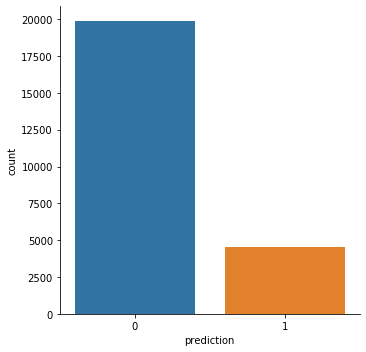

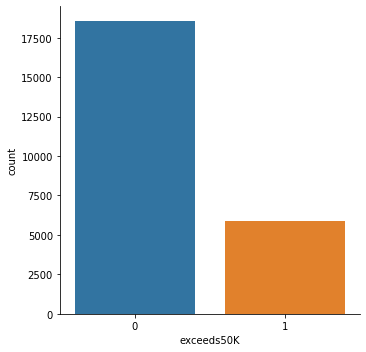

In [38]:
sns.catplot(x="prediction", kind="count", data=df)
sns.catplot(x="exceeds50K", kind="count", data=train)

In [35]:
if not os.path.exists(os.path.join('dump', 'RF_simpleonehotencodingonly')):
    os.mkdir(os.path.join('dump', 'RF_simpleonehotencodingonly'))

X_train.to_csv(os.path.join('dump', 'RF_simpleonehotencodingonly', 'X_train.csv'))
X_test.to_csv(os.path.join('dump', 'RF_simpleonehotencodingonly', 'X_test.csv'))
pickle.dump(final_model, open(os.path.join('dump', 'RF_simpleonehotencodingonly', 'model'), 'wb'))
df.to_csv(os.path.join('dump', 'RF_simpleonehotencodingonly', 'RF_simpleonehotencodingonly.csv'))

# Features importance

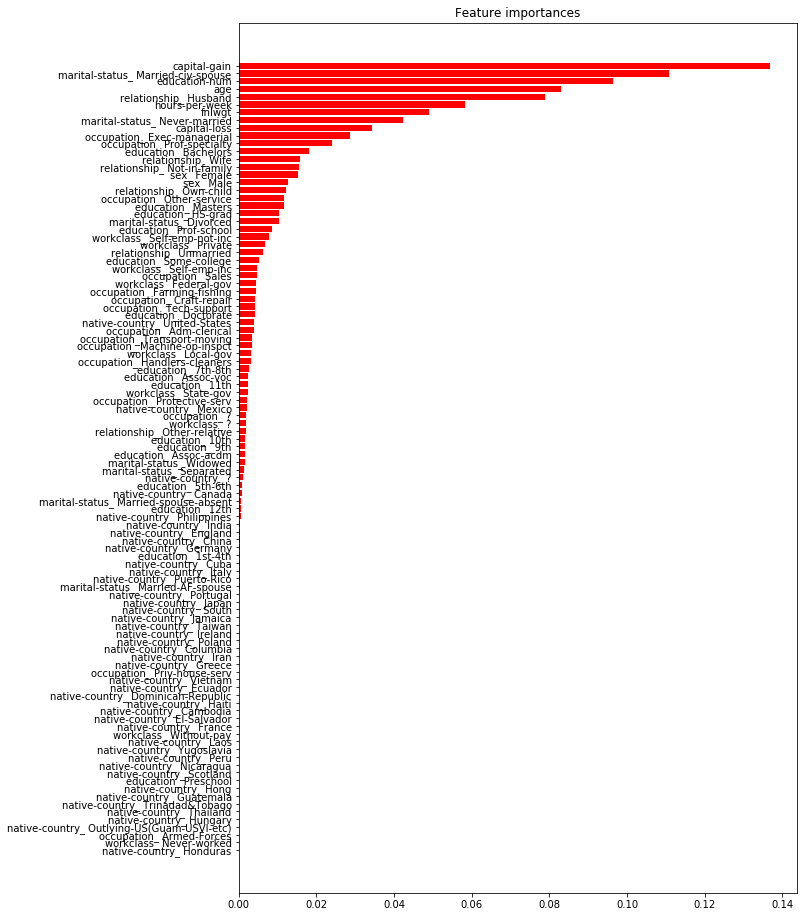

In [34]:
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
colnames = list(X_train)

fig, ax = plt.subplots(1, 1, figsize=(10,16))
ax.set_title("Feature importances")
ax.barh(range(len(colnames)), importances[indices[::-1]],
        color="r", align="center")
ax.set_yticks(range(len(colnames)))
ax.set_yticklabels(np.array(colnames)[indices][::-1])
plt.show()